In [1]:
%load_ext autoreload
%autoreload 2

## Medchem

Medchem is a package for applying general filtering rules on a set of molecules to ensure they have drug-like properties.

In this tutorial, we will apply various filtering on an example dataset to get highlight the package API

### Setup

In [99]:
import datamol as dm
import numpy as np
from loguru import logger

data = dm.data.freesolv().sample(500)
smiles_list = data.smiles.values

In [102]:
from medchem.filter import lead
from medchem.demerits import score, batch_score
from medchem.alerts import NovartisFilters
from medchem.alerts import AlertFilters
from medchem.catalog import NamedCatalogs
from medchem.utils import get_data
from rdkit.Chem import FilterCatalog

### Using the filter module

The filter module provides a variety of two types of filters:
-  `generic`: custom filtering based on some given molecule properties such as number of atoms, presence of specific atom type, etc
-  `lead`: filtering based on structural motifs that are known to either be toxic, reactive, unstable or frequent false positive

In [4]:
# common filters including pains, brenk, nih, zinc
pains_a = FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_A
lead.catalog_filter(smiles_list, ["nih", pains_a, NamedCatalogs.dundee()])

array([ True,  True,  True, False, False,  True, False, False,  True,
       False,  True, False,  True, False,  True, False, False, False,
       False,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True,  True, False, False,  True, False, False,
        True,  True, False,  True, False, False, False, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True, False, False,
       False, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False, False, False,
       False, False,  True,  True, False, False,  True,  True, False,
       False, False,  True, False, False, False,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True, False,
       False,  True,

In [6]:
# filtering based on some commons alerts + additional lead like rules
lead.alert_filter(smiles_list, alerts=["Glaxo", "BMS"], rule_dict=dict(MW=[0, 100]))

array([ True, False, False, False, False, False, False,  True,  True,
       False, False,  True, False, False,  True, False, False, False,
       False, False,  True,  True, False, False,  True, False, False,
       False, False, False,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True,  True, False,
        True, False,  True, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False,  True,  True, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
        True, False,  True, False, False, False,  True, False, False,
        True, False, False,  True, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False,

In [7]:
# filtering based on NIBR screening deck process described in
# "Evolution of Novartis' small molecule screening deck design" by Schuffenhauer, A. et al. J. Med. Chem. (2020),
# https://dx.doi.org/10.1021/acs.jmedchem.0c01332.
lead.screening_filter(smiles_list, return_idx=True)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,  40,  41,
        42,  43,  44,  45,  46,  48,  49,  51,  52,  53,  55,  56,  57,
        58,  59,  60,  61,  63,  64,  65,  66,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  83,  84,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 149, 151, 152, 153, 154, 155, 156,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 19

In [8]:
# Filter based on the demerit scoring of Eli Lilly
test_config = {
    "output": "test",
    "min_atoms": 10,
    "soft_max_atoms": 30,
    "hard_max_atoms": 50,
    "smarts": [],
    "nodemerit": False,
    "dthresh": 160,
    "odm": [],
    "okiso": False,
    "noapdm": False,
}
lead.lilly_demerit_filter(smiles_list, max_demerits=160, return_idx=True, **test_config)

array([  1,   6,  19,  37,  46,  49,  66,  70,  71,  74,  87, 124, 130,
       135, 136, 144, 147, 174, 182, 184, 194, 195, 198, 203, 204, 232,
       235, 236, 244, 245, 255, 256, 261, 267, 268, 274, 297, 307, 326,
       340, 349, 359, 367, 369, 373, 380, 398, 403, 409, 420, 423, 428,
       429, 430, 432, 446, 451, 456, 460, 462, 463, 481, 484, 485, 493,
       494])

### Advanced options

The advanced options allow a better control over the filtering process. They also provide more information on the issues with the molecules.

#### AlertFilters

These are the underlying filters called by `lead.alert_filter`. In the output, the compound status is indicated as either `"Exclude"` or `"Ok"`.

In [9]:
filter_obj = AlertFilters(alerts_set=["inpharmatica", "SureChEMBL"])
filter_obj.list_default_available_alerts()

,rule_set_name,smarts,catalog_description,rule_set,source
10,Glaxo,55,Glaxo Wellcome Hard filters,1,ChEMBL
5,Dundee,105,University of Dundee NTD Screening Library Fil...,2,ChEMBL
2,BMS,180,Bristol-Myers Squibb HTS Deck filters,3,ChEMBL
18,PAINS,481,PAINS filters,4,ChEMBL
21,SureChEMBL,166,SureChEMBL Non-MedChem Friendly SMARTS,5,ChEMBL
16,MLSMR,116,NIH MLSMR Excluded Functionality filters (MLSMR),6,ChEMBL
12,Inpharmatica,91,Unwanted fragments derived by Inpharmatica Ltd.,7,ChEMBL
14,LINT,57,Pfizer lint filters (lint),8,ChEMBL
0,Alarm-NMR,75,Reactive False Positives in Biochemical Screen...,9,Litterature
1,AlphaScreen-Hitters,6,Structural filters for compounds that may be a...,10,Litterature


In [10]:
out = filter_obj(smiles_list)
out

,_smiles,status,reasons,MW,LogP,HBD,HBA,TPSA
0,c1ccncc1,Ok,None,79.102,1.0816,0,1,12.89
1,CN(C)CCC=C1c2ccccc2CCc2ccccc21,Ok,None,277.411,4.1686,0,1,3.24
2,O=c1[nH]cc(Cl)c(=O)[nH]1,Ok,None,146.533,-0.2834,2,2,65.72
3,CCCCCCc1ccccc1,Ok,None,162.276,3.8094,0,0,0.00
4,CCCCCC(C)=O,Ok,None,114.188,2.1557,0,1,17.07
...,...,...,...,...,...,...,...,...
495,CCCCN,Ok,None,73.139,0.7452,1,1,26.02
496,C[C@H](O)C(F)(F)F,Ok,None,114.066,0.9295,1,1,20.23
497,C=CCCCCCC,Exclude,Ethene,112.216,3.1428,0,0,0.00
498,Clc1ccccc1-c1ccccc1,Ok,None,188.657,4.0070,0,0,0.00


#### NovartisFilter

These are the underlying filters called by `lead.screening_filter`. 

Here is an explanation of the output:
- **status**: one of `["Exclude", "Flag", "Annotations", "Ok"]` (ordered by quality). Generally, you can keep anything without the "Exclude" label, as long as you also apply a maximum severity score for compounds that collects too many flags.
- **covalent**: number of potentially covalent motifs contained in the compound
- **severity**: how severe are the issues with the molecules:
      - `0`: compound has no flags, might have annotations;
      - `1-9`:  number of flags the compound raises;
      - `>= 10`:  default exclusion criterion used in the paper
- **special_mol**: whether the compound/parts of the compound belongs to a special class of molecules (e.g peptides, glycosides, fatty acid). In that case, you should review the rejection reasons.

In [11]:
filter_obj = NovartisFilters()
out = filter_obj(smiles_list)
out

,_smiles,status,reasons,severity,covalent,special_mol
0,c1ccncc1,Ok,None,0,NaN,NaN
1,CN(C)CCC=C1c2ccccc2CCc2ccccc21,Ok,None,0,NaN,NaN
2,O=c1[nH]cc(Cl)c(=O)[nH]1,Ok,None,0,NaN,NaN
3,CCCCCCc1ccccc1,Ok,None,0,NaN,NaN
4,CCCCCC(C)=O,Ok,None,0,NaN,NaN
...,...,...,...,...,...,...
495,CCCCN,Ok,None,0,NaN,NaN
496,C[C@H](O)C(F)(F)F,Ok,None,0,NaN,NaN
497,C=CCCCCCC,Ok,None,0,NaN,NaN
498,Clc1ccccc1-c1ccccc1,Ok,None,0,NaN,NaN


#### Demerits scoring

Demerit scoring uses the Eli Lilly filter rules. Those are complex rules, that can be customized in any way you wish. 

The following "information" will be computed and added as columns to a DataFrame for each run:

- **status**: this was added for compatibility and has values `"Exclude"`, `"Flag"` or `"Ok"`.
- **rejected** : whether the molecule pass the filter or was rejected
- **reasons**: the reasons why the molecule was rejected if available
- **demerit_score** a demerit score for molecules. The lower the better. A cutoff is used to reject molecule with too many demerits, which you can refilter again after.
- **step**: step of the pipeline where molecule was filtered out, if available



In [12]:
out = score(smiles_list, **test_config)
out

,_smiles,ID,reasons,step,rejected,demerit_score,status
0,C1=CC=NC=C1,0,not_enough_atoms,1,True,NaN,Exclude
1,CN(C)CCC=C1C2=CC=CC=C2CCC2=C1C=CC=C2,1,NaN,4,False,0.0,Ok
2,C1=C(Cl)C(=O)NC(=O)N1,2,not_enough_atoms,1,True,NaN,Exclude
3,CCCCCCC1=CC=CC=C1,3,no_interesting_atoms,1,True,NaN,Exclude
4,CCCCCC(=O)C,4,not_enough_atoms,1,True,NaN,Exclude
...,...,...,...,...,...,...,...
495,CCCCN,495,not_enough_atoms,1,True,NaN,Exclude
496,C[C@H](O)C(F)(F)F,496,not_enough_atoms,1,True,NaN,Exclude
497,CCCCCCC=C,497,not_enough_atoms,1,True,NaN,Exclude
498,C1=CC=C(C=C1)C1=CC=CC=C1Cl,498,no_interesting_atoms,1,True,NaN,Exclude


In [13]:
# Although the demirits.score is already quite fast, you can also call the parallelized version of it using the `batch_score` function

In [14]:
out2 = batch_score(smiles_list, n_jobs=2,  batch_size=100,  progress=True, **test_config)
out2

100%|██████████| 5/5 [00:00<00:00,  9.50it/s]


,_smiles,ID,reasons,step,rejected,demerit_score,status
0,C1=CC=NC=C1,0,not_enough_atoms,1,True,NaN,Exclude
1,CN(C)CCC=C1C2=CC=CC=C2CCC2=C1C=CC=C2,1,NaN,4,False,0.0,Ok
2,C1=C(Cl)C(=O)NC(=O)N1,2,not_enough_atoms,1,True,NaN,Exclude
3,CCCCCCC1=CC=CC=C1,3,no_interesting_atoms,1,True,NaN,Exclude
4,CCCCCC(=O)C,4,not_enough_atoms,1,True,NaN,Exclude
...,...,...,...,...,...,...,...
495,CCCCN,495,not_enough_atoms,1,True,NaN,Exclude
496,C[C@H](O)C(F)(F)F,496,not_enough_atoms,1,True,NaN,Exclude
497,CCCCCCC=C,497,not_enough_atoms,1,True,NaN,Exclude
498,C1=CC=C(C=C1)C1=CC=CC=C1Cl,498,no_interesting_atoms,1,True,NaN,Exclude


### Functional group filters

It is also possible to initialize a list of functional group to use for molecules matching

In [96]:
from medchem.groups import ChemicalGroup
c_group = ChemicalGroup(groups="rings_in_drugs")

In [97]:
mol = dm.to_mol("CCS(=O)(=O)N1CC(C1)(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3")
c_group.get_matches(mol, use_smiles=True)


,name,smiles,smarts,group,matches
204,diazine,C1=NC=CC=N1,[#6]1:[#7]:[#6]:[#6]:[#6]:[#7]:1,rings_in_drugs,"((24, 23, 22, 18, 17, 25),)"
234,1H-pyrazole,N1=CC=CN1,[#7]1:[#6]:[#6]:[#6]:[#7H]:1,rings_in_drugs,"((12, 13, 14, 15, 16),)"
257,1H-pyrrole,C1=CC=CN1,[#6]1:[#6]:[#6]:[#6]:[#7H]:1,rings_in_drugs,"((20, 19, 18, 22, 21),)"


You can also load a custom library of queries. You custom df needs to provide the following columns:
`'smiles'/'smarts'`, `'name'` and `"group"` and optionally  `'hierarchy'`


In [103]:
c_group = ChemicalGroup(groups_db=get_data("smarts_bank.csv"))
c_group.get_matches(mol, use_smiles=False)

,name,smiles,smarts,group,matches
0,HBA,,"[!$([#6,F,Cl,Br,I,o,s,nX3,#7v5,#15v5,#16v4,#16...",custom_queries,"((3,), (4,), (5,), (11,), (16,), (23,), (25,))"
2,HBD,,"[!$([#6,H0,-,-2,-3])]",custom_queries,"((21,),)"
3,HBD,,"[!H0;#7,#8,#9]",custom_queries,"((21,),)"
12,Hydrogen,,"[*!H0,#1]",custom_queries,"((0,), (1,), (6,), (8,), (9,), (13,), (15,), (..."
13,Hydrogen,,"[#6!H0,#1]",custom_queries,"((0,), (1,), (6,), (8,), (9,), (13,), (15,), (..."
14,Hydrogen,,"[H,#1]",custom_queries,"((13,), (15,), (19,), (20,), (21,), (24,))"
16,Acyclic Bonds,,*!@*,custom_queries,"((0, 1), (1, 2), (2, 3), (2, 4), (2, 5), (7, 9..."
18,Rotable Bond,,[!$(*#*)&!D1]-!@[!$(*#*)&!D1],custom_queries,"((1, 2), (2, 5), (7, 9), (7, 12), (14, 17))"
20,SP3 Nitrogen,,"[$([NX4+]),$([NX3]);!$(*=*)&!$(*:*)]",custom_queries,"((5,),)"
21,SP2 Nitrogen,,"[$([nX3](:*):*),$([nX2](:*):*),$([#7X2]=*),$([...",custom_queries,"((12,), (16,), (21,), (23,), (25,))"


### PhysChem Rule application

You can also apply a set of physchem rules to a list of compounds

You can apply the basic rules independently

In [21]:
from medchem.rules.basic_rules import rule_of_five, rule_of_three

In [22]:
print("RO5", rule_of_five(mol))
print("RO3", rule_of_three(mol))

RO5 True
RO3 False


To list all available rules and what they are good for, use :

In [23]:
from medchem.rules import RuleFilters

In [27]:
RuleFilters.list_available_rules()

,name,rules,comments
0,rule_of_five,MW <= 500 & logP <= 5 & HBD <= 5 & HBA <= 10,leadlike;druglike;small molecule;library design
1,rule_of_five_beyond,"MW <= 1000 & logP in [-2, 10] & HBD <= 6 & HBA...",leadlike;druglike;small molecule;library design
2,rule_of_four,MW >= 400 & logP >= 4 & RINGS >=4 & HBA >= 4,PPI inhibitor;druglike
3,rule_of_three,MW <= 300 & logP <= 3 & HBA <= 3 & HBD <= 3 & ...,fragment;building block
4,rule_of_three_extended,"MW <= 300 & logP in [-3, 3] & HBA <= 6 & HBD <...",fragment;building block
5,rule_of_two,MW <= 200 & logP <= 2 & HBA <= 4 & HBD <= 2,fragment;reagent;building block
6,rule_of_ghose,"MW in [160, 480] & logP in [-0.4, 5.6] & Natom...",leadlike;druglike;small molecule;library design
7,rule_of_veber,rotatable bond <= 10 & TPSA < 140,druglike;leadlike;small molecule;oral
8,rule_of_reos,"MW in [200, 500] & logP in [-5, 5] & HBA in [0...",druglike;small molecule;library design;HTS
9,rule_of_chemaxon_druglikeness,MW < 400 & logP < 5 & HBA <= 10 & HBD <= 5 & r...,leadlike;druglike;small molecule


To list the available rules for small molecules only,  you can use the `list_available_rules("small molecule")`

In [56]:
RuleFilters.list_available_rules("small molecule")

,name,rules,description
0,rule_of_five,MW <= 500 & logP <= 5 & HBD <= 5 & HBA <= 10,leadlike;druglike;small molecule;library design
1,rule_of_five_beyond,"MW <= 1000 & logP in [-2, 10] & HBD <= 6 & HBA...",leadlike;druglike;small molecule;library design
6,rule_of_ghose,"MW in [160, 480] & logP in [-0.4, 5.6] & Natom...",leadlike;druglike;small molecule;library design
7,rule_of_veber,rotatable bond <= 10 & TPSA < 140,druglike;leadlike;small molecule;oral
8,rule_of_reos,"MW in [200, 500] & logP in [-5, 5] & HBA in [0...",druglike;small molecule;library design;HTS
9,rule_of_chemaxon_druglikeness,MW < 400 & logP < 5 & HBA <= 10 & HBD <= 5 & r...,leadlike;druglike;small molecule
10,rule_of_egan,"TPSA in [0, 132] & logP in [-1, 6]",druglike;small molecule;admet;absorption;perme...
11,rule_of_pfizer_3_75,not (TPSA < 75 & logP > 3),druglike;toxicity;invivo;small molecule
12,rule_of_gsk_4_400,MW <= 400 & logP <= 4,druglike;admet;small molecule
13,rule_of_oprea,"HBD in [0, 2] & HBA in [2, 9] & ROTBONDS in [2...",druglike;small molecule


You can also apply the rule filter to a batch of molecules.

In [57]:
rule_obj = RuleFilters(rule_list=["rule_of_five", "rule_of_oprea", "rule_of_cns"], rule_list_names=["rule_of_five", "rule_of_oprea", "rule_of_cns"], precompute_props=True)

In [58]:
out = rule_obj(smiles_list, n_jobs=-1, progress=True)
# you need to reset the columns because the input rule list can be columns
out

100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


,rule_of_five,rule_of_oprea,rule_of_cns
0,True,False,False
1,True,False,True
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
495,True,False,False
496,True,False,False
497,True,False,False
498,True,False,False


### Available Catalogs

For a list of all available named catalogs, you can use `catalog.list_named_catalogs`

In [61]:
from medchem import catalog
print(catalog.list_named_catalogs())

['tox', 'pains', 'pains_a', 'pains_b', 'pains_c', 'nih', 'zinc', 'brenk', 'dundee', 'bms', 'glaxo', 'schembl', 'mlsmr', 'inpharmatica', 'lint', 'alarm_nmr', 'alphascreen', 'gst_hitters', 'his_hitters', 'luciferase', 'dnabinder', 'chelator', 'hitters', 'electrophilic', 'carcinogen', 'ld50_oral', 'reactive_unstable_toxic', 'skin', 'toxicophore', 'nibr', 'bredt', 'unstable_graph', 'chemical_groups']


### Build custom catalogs
You can build a custom catalog based on smarts you have defined. For example, using an internal smarts bank.

In [73]:
from medchem.catalog import from_smarts
import pandas as pd

In [104]:
smarts_bank = pd.read_csv(get_data("smarts_bank.csv"))

In [105]:
custom_catalog = from_smarts(smarts_bank.smarts.values, smarts_bank.name.values, entry_as_inds=False)

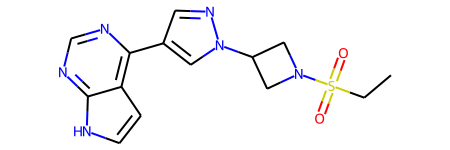

In [106]:
mol = "CCS(=O)(=O)N1CC(C1)N2C=C(C=N2)C3=C4C=CNC4=NC=N3"
mol = dm.to_mol(mol)
mol

In [107]:
matches = custom_catalog.GetMatches(mol)
[m.GetDescription() for m in matches]

['HBA',
 'HBD',
 'HBD',
 'Hydrogen',
 'Hydrogen',
 'Hydrogen',
 'Acyclic Bonds',
 'Rotable Bond',
 'SP3 Nitrogen',
 'SP2 Nitrogen',
 'SP2 Carbon',
 'Aromatic SP2 Carbon',
 'Chiral Carbon']